In [1]:
!nvidia-smi # Run this to see what GPU you have

Thu Oct  3 04:31:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   63C    P8              18W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
# !pip install wandb --quiet # Install WandB
# !pip install pytorch_metric_learning --quiet #Install the Pytorch Metric Library

In [3]:
import torch
from torchsummary import summary
import torchvision
from torchvision import transforms
import torch.nn.functional as F
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from pytorch_metric_learning import samplers, losses
from sklearn import metrics as mt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import glob
import wandb
import matplotlib.pyplot as plt
from pytorch_metric_learning import samplers
import csv
import numpy as np
from torch.utils.data import default_collate
from collections import defaultdict

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)


Device:  cuda


In [4]:
# TODO: Use the same Kaggle code from HW1P2
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"aaayush1","key":"9ad570c944c8b67cf242fb16c7cf3f40"}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

  Using cached kaggle-1.5.8-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [5]:
# # # Reminder: Make sure you have connected your kaggle API before running this block
# !mkdir '/content/data'

# !kaggle competitions download -c 11785-hw-2-p-2-face-verification-fall-2024
# !unzip -qo '11785-hw-2-p-2-face-verification-fall-2024.zip' -d '/content/data'

In [6]:
config = {
    'batch_size': 1024, # Increase this if your GPU can handle it
    'lr': 1e-4,
    'epochs': 60, # 20 epochs is recommended ONLY for the early submission - you will have to train for much longer typically.
    'data_dir': "/content/data/11-785-f24-hw2p2-verification/cls_data", #TODO
    'data_ver_dir': "/content/data/11-785-f24-hw2p2-verification/ver_data", #TODO
    'checkpoint_dir': "/content/checkpoint" #TODO
    # Include other parameters as needed.
}

In [7]:
class ImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2, match = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2), int(match)

In [8]:
class TestImagePairDataset(torch.utils.data.Dataset):

    def __init__(self, data_dir, csv_file, transform):
        self.data_dir = data_dir
        self.transform = transform
        self.pairs = []
        if csv_file.endswith('.csv'):
            with open(csv_file, 'r') as f:
                reader = csv.reader(f)
                for i, row in enumerate(reader):
                    if i == 0:
                        continue
                    else:
                        self.pairs.append(row)
        else:
            with open(csv_file, 'r') as f:
                for line in f.readlines():
                    self.pairs.append(line.strip().split(' '))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):

        img_path1, img_path2 = self.pairs[idx]
        img1 = Image.open(os.path.join(self.data_dir, img_path1))
        img2 = Image.open(os.path.join(self.data_dir, img_path2))
        return self.transform(img1), self.transform(img2)

In [9]:
data_dir = config['data_dir']
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'dev')

# train transforms
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    torchvision.transforms.RandomRotation(degrees=15),  # Random rotation
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # color jitter
    torchvision.transforms.GaussianBlur(kernel_size=(3, 5), sigma=(0.1, 3)),
    torchvision.transforms.ToTensor(),  # Convert to tensor
    torchvision.transforms.RandomErasing(p=0.4),  # Random erasing
    torchvision.transforms.Normalize(mean=[0.5309, 0.4139, 0.3587], std=[0.2837, 0.2472, 0.2380])  # Normalize
])


val_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(112),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5309, 0.4139, 0.3587], std=[0.2837, 0.2472, 0.2380])])

In [10]:
# import torch
# import numpy as np
# from collections import defaultdict
# import torchvision

# class ContrastiveSampler(torch.utils.data.Sampler):
#     def __init__(self, dataset: torch.utils.data.Dataset, A: int, P: int, N: int, batch_size: int):
#         self.dataset = dataset
#         self.A = A  # Number of anchors
#         self.P = P  # Number of positives per anchor
#         self.N = N  # Number of negatives per anchor
#         self.batch_size = batch_size
#         self.class_to_indices = self._create_class_index_mapping()
#         self.all_indices = np.arange(len(self.dataset))
#         self.unique_classes = list(self.class_to_indices.keys())

#         # Precompute negative pools for each class
#         self.class_negative_pools = {
#             cls: np.setdiff1d(self.all_indices, self.class_to_indices[cls], assume_unique=True)
#             for cls in self.class_to_indices
#         }

#     def _create_class_index_mapping(self):
#         """Create a mapping from class labels to list of indices."""
#         class_to_indices = defaultdict(list)
#         for idx, (_, label) in enumerate(self.dataset.imgs):
#             class_to_indices[label].append(idx)
#         for cls in class_to_indices:
#             class_to_indices[cls] = np.array(class_to_indices[cls])
#         return class_to_indices

#     def __iter__(self):
#         """Return batches of indices for contrastive training."""
#         seen_indices = np.zeros(len(self.dataset), dtype=bool)  # Use a boolean mask
#         remaining_indices = np.arange(len(self.dataset))

#         while np.sum(~seen_indices) >= self.A:
#             batch_indices = []
#             available_indices = remaining_indices[~seen_indices[remaining_indices]]
#             if len(available_indices) < self.A:
#                 break

#             anchors = np.random.choice(available_indices, size=self.A, replace=False)

#             for anchor_idx in anchors:
#                 anchor_label = self.dataset.imgs[anchor_idx][1]
#                 batch_indices.append(anchor_idx)
#                 seen_indices[anchor_idx] = True

#                 # Sample positives
#                 positive_pool = self.class_to_indices[anchor_label]
#                 positive_pool = positive_pool[~seen_indices[positive_pool]]
#                 num_pos = min(self.P, len(positive_pool))
#                 if num_pos > 0:
#                     positives = np.random.choice(positive_pool, size=num_pos, replace=False)
#                     batch_indices.extend(positives)
#                     seen_indices[positives] = True

#                 # Sample negatives
#                 negative_pool = self.class_negative_pools[anchor_label]
#                 negative_pool = negative_pool[~seen_indices[negative_pool]]
#                 num_neg = min(self.N, len(negative_pool))
#                 if num_neg > 0:
#                     negatives = np.random.choice(negative_pool, size=num_neg, replace=False)
#                     batch_indices.extend(negatives)
#                     seen_indices[negatives] = True

#             yield batch_indices

#     def __len__(self):

#       num_batches = len(self.dataset) // self.batch_size


#       if len(self.dataset) % self.batch_size != 0:
#           num_batches += 1

#       return num_batches


# train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)

# sampler = ContrastiveSampler(train_dataset, A=256, P=1, N=2, batch_size=1024)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler, shuffle=False, num_workers=8, pin_memory=True)



In [11]:
train_dataset = torchvision.datasets.ImageFolder(train_dir, transform=train_transforms)


# Create MPerClassSampler
sampler = samplers.MPerClassSampler(train_dataset.targets, m=3, length_before_new_iter=450000)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                            batch_size=config["batch_size"],
                                            pin_memory=True,
                                            num_workers=8,
                                            sampler=sampler)

In [12]:
# # Example of iterating through the DataLoader
# for i, (img_batch, target_batch) in enumerate(train_loader):
#   print(i)
#   # print(f"Image batch shape: {img_batch.shape}, Target batch shape: {target_batch.shape}")
#     # print(target_batch)


# len(train_loader)

In [13]:
val_dataset = torchvision.datasets.ImageFolder(val_dir, transform=val_transforms)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                          batch_size=config["batch_size"],
                                          shuffle=False,
                                          num_workers=4)

In [14]:
data_dir = config['data_ver_dir']
print("data_ver_dir", data_dir)


# get datasets

# TODO: Add your validation pair txt file
pair_dataset = ImagePairDataset(data_dir, csv_file='/content/data/11-785-f24-hw2p2-verification/val_pairs.txt', transform=val_transforms)
pair_dataloader = torch.utils.data.DataLoader(pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

# TODO: Add your validation pair txt file
test_pair_dataset = TestImagePairDataset(data_dir, csv_file='/content/data/11-785-f24-hw2p2-verification/test_pairs.txt', transform=val_transforms)
test_pair_dataloader = torch.utils.data.DataLoader(test_pair_dataset,
                                              batch_size=config["batch_size"],
                                              shuffle=False,
                                              pin_memory=True,
                                              num_workers=4)

data_ver_dir /content/data/11-785-f24-hw2p2-verification/ver_data


#EDA and Viz

In [15]:
# Double-check your dataset/dataloaders work as expected

print("Number of classes    : ", len(train_dataset.classes))
print("No. of train images  : ", train_dataset.__len__())
print("Shape of image       : ", train_dataset[0][0].shape)
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Val batches          : ", val_loader.__len__())

# Feel free to print more things if needed

Number of classes    :  8631
No. of train images  :  431550
Shape of image       :  torch.Size([3, 112, 112])
Batch size           :  1024
Train batches        :  439
Val batches          :  43


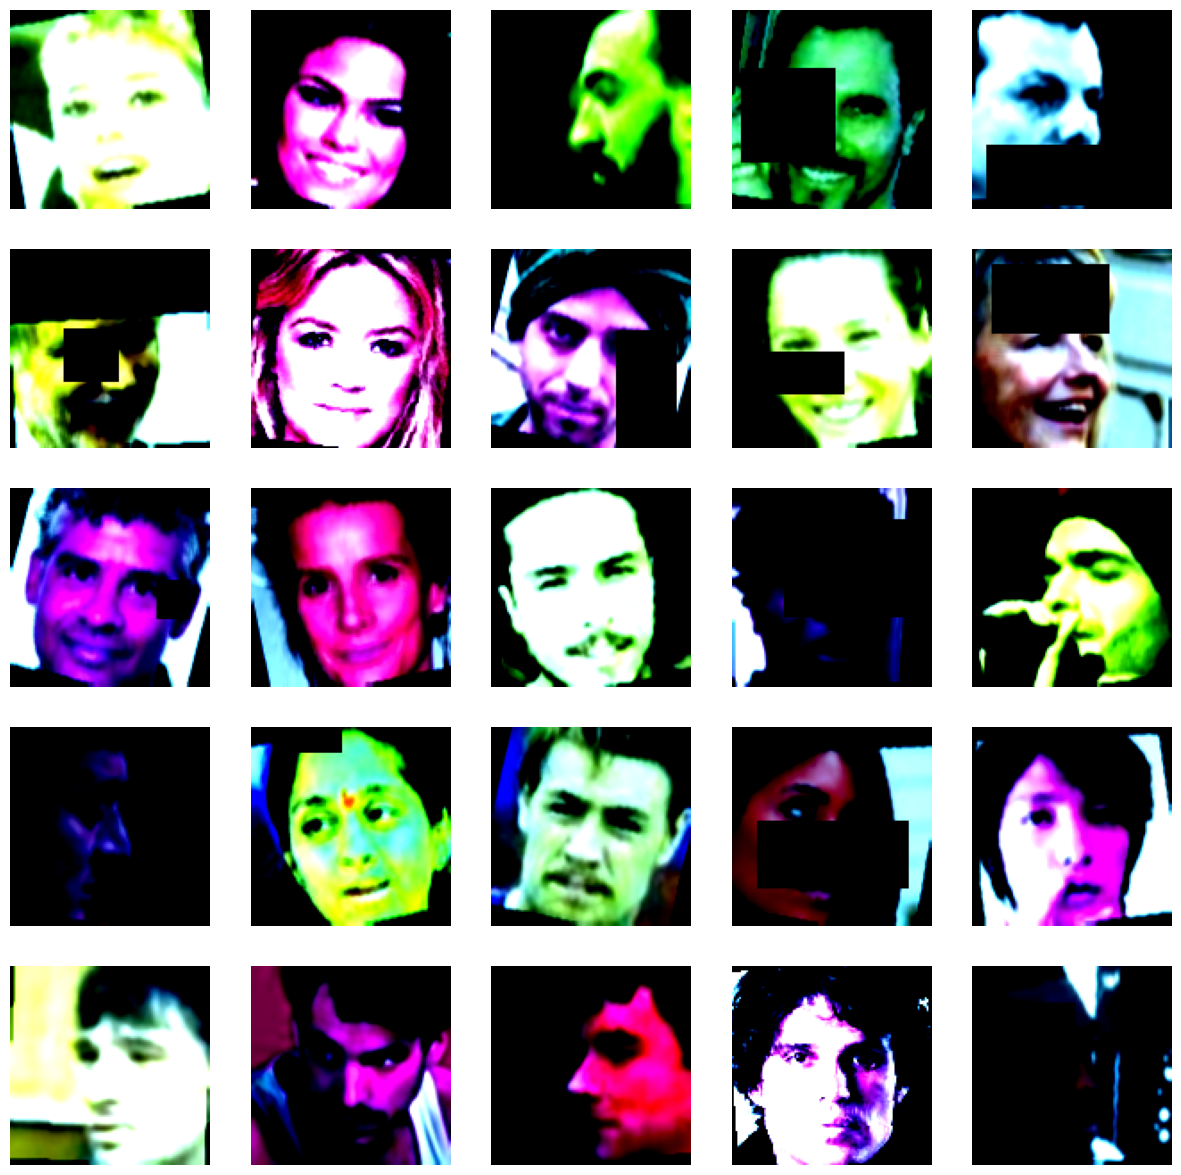

In [16]:
# Visualize a few images in the dataset

"""
You can write your own code, and you don't need to understand the code
It is highly recommended that you visualize your data augmentation as sanity check
"""

r, c    = [5, 5]
fig, ax = plt.subplots(r, c, figsize= (15, 15))

k       = 0
dtl     = torch.utils.data.DataLoader(
    dataset     = torchvision.datasets.ImageFolder(train_dir, transform= train_transforms), # dont wanna see the images with transforms
    batch_size  = config['batch_size'],
    shuffle     = True)

for data in dtl:
    x, y = data

    for i in range(r):
        for j in range(c):
            img = x[k].numpy().transpose(1, 2, 0)
            ax[i, j].imshow(img)
            ax[i, j].axis('off')
            k+=1
    break

del dtl

In [17]:
# Identity Block
class IdentityBlock(torch.nn.Module):

  def __init__(self, in_channels, filters, stride=1):
    super(IdentityBlock, self).__init__()

    f1, f2, f3 = filters
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=f1, kernel_size=1, stride=stride)
    self.bn1 = torch.nn.BatchNorm2d(f1)

    self.conv2 = torch.nn.Conv2d(in_channels=f1, out_channels=f2, kernel_size=3, stride=stride, padding=1)
    self.bn2 = torch.nn.BatchNorm2d(f2)

    self.conv3 = torch.nn.Conv2d(in_channels=f2, out_channels=f3, kernel_size=1, stride=stride)
    self.bn3 = torch.nn.BatchNorm2d(f3)

    self.relu = torch.nn.ReLU()


  def forward(self, x):
    identity = x


    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)


    out += identity

    out = self.relu(out)

    return out


# Projection Block
class ProjectionBlock(torch.nn.Module):

  def __init__(self, in_channels, filters, stride=2):
    super(ProjectionBlock, self).__init__()

    f1, f2, f3 = filters
    self.conv1 = torch.nn.Conv2d(in_channels=in_channels, out_channels=f1, kernel_size=1, stride=stride)
    self.bn1 = torch.nn.BatchNorm2d(f1)

    self.conv2 = torch.nn.Conv2d(in_channels=f1, out_channels=f2, kernel_size=3, stride=1, padding=1)
    self.bn2 = torch.nn.BatchNorm2d(f2)

    self.conv3 = torch.nn.Conv2d(in_channels=f2, out_channels=f3, kernel_size=1, stride=1)
    self.bn3 = torch.nn.BatchNorm2d(f3)

    self.shortcut = torch.nn.Conv2d(in_channels, f3, kernel_size=1, stride=stride)
    self.shortcut_bn = torch.nn.BatchNorm2d(f3)

    self.relu = torch.nn.ReLU()


  def forward(self, x):
    identity = self.shortcut_bn(self.shortcut(x))

    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)

    out = self.conv2(out)
    out = self.bn2(out)
    out = self.relu(out)

    out = self.conv3(out)
    out = self.bn3(out)
    out += identity

    out = self.relu(out)

    return out

In [18]:
class ResNet101(torch.nn.Module):
    def __init__(self, num_classes=8631):
        super(ResNet101, self).__init__()

        self.conv1 = torch.nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = torch.nn.BatchNorm2d(64)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layer 1 (64 -> 256)
        self.layer1 = torch.nn.Sequential(
            ProjectionBlock(64, [64, 64, 256], stride=1),  # Note: stride=1 for Layer 1
            IdentityBlock(256, [64, 64, 256]),
            IdentityBlock(256, [64, 64, 256])
        )

        # Layer 2 (128 -> 512)
        self.layer2 = torch.nn.Sequential(
            ProjectionBlock(256, [128, 128, 512], stride=2),
            IdentityBlock(512, [128, 128, 512]),
            IdentityBlock(512, [128, 128, 512]),
            IdentityBlock(512, [128, 128, 512])
        )

        # Layer 3 (256 -> 1024) - ResNet101 has 23 blocks here
        self.layer3 = torch.nn.Sequential(
            ProjectionBlock(512, [256, 256, 1024], stride=2),
            *[IdentityBlock(1024, [256, 256, 1024]) for _ in range(22)]  # 23 identity blocks
        )

        # Layer 4 (512 -> 2048)
        self.layer4 = torch.nn.Sequential(
            ProjectionBlock(1024, [512, 512, 2048], stride=2),
            IdentityBlock(2048, [512, 512, 2048]),
            IdentityBlock(2048, [512, 512, 2048])
        )

        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = torch.nn.Flatten()
        self.fc = torch.nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = self.flatten(x)
        out = self.fc(x)

        return x

# model = ResNet101().to(DEVICE)

In [19]:
class ProjectionLayer(torch.nn.Module):
    '''Projection layer with L2 normalization to map high-dimensional features
       to a lower-dimensional space for contrastive learning.'''
    def __init__(self, input_dim=2048, hidden_dim=1024, output_dim=512):
        super(ProjectionLayer, self).__init__()


        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)

        return x

In [20]:
class ResNetWithProjection(torch.nn.Module):
    def __init__(self):
        super(ResNetWithProjection, self).__init__()
        self.resnet = ResNet101()
        self.projection = ProjectionLayer(input_dim=2048, hidden_dim=1024, output_dim=512)
        self.use_projection = True

    def forward(self, x):
        # Pass through the ResNet101 network
        feats = self.resnet(x)

        if self.use_projection:
            # Pass through the projection layer
            projection = self.projection(feats)
            projection = F.normalize(projection, p=2, dim=1)
            return projection
        else:
            # Skip the projection layer during inference
            return feats

model = ResNetWithProjection().to(DEVICE)


In [21]:
checkpoint = torch.load('/content/checkpoint/best_ret_167.pth')

# Restore model and optimizer state
model.resnet.load_state_dict(checkpoint['model_state_dict'])

<ipython-input-21-add86e90bae5>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/content/checkpoint/best_ret_167.pth')


<All keys matched successfully>

In [22]:
for param in model.resnet.fc.parameters():
    param.requires_grad = False

In [23]:
# --------------------------------------------------- #

# Defining Loss function
criterion = losses.SubCenterArcFaceLoss(num_classes=8631, embedding_size=512, margin=0.5, scale=64, sub_centers=3).to(DEVICE)


# --------------------------------------------------- #

# Defining Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'],  weight_decay=1e-3)

# --------------------------------------------------- #

# Defining Scheduler

# warmup_epochs = 5
# cosine_epochs = config['epochs'] - warmup_epochs

# warmup_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.01, end_factor=0.1, total_iters=warmup_epochs)


# cosine_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cosine_epochs)

# scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, schedulers=[warmup_scheduler, cosine_scheduler], milestones=[warmup_epochs])

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config['epochs'])

# --------------------------------------------------- #

# Initialising mixed-precision training. # Good news. We've already implemented FP16 (Mixed precision training) for you
# It is useful only in the case of compatible GPUs such as T4/V100
scaler = torch.cuda.amp.GradScaler()

<ipython-input-23-3e75fbd48b51>:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [24]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    maxk = min(max(topk), output.size()[1])
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    target = target.argmax(dim=1)
    correct = pred.eq(target.reshape(1, -1).expand_as(pred))
    return [correct[:min(k, maxk)].reshape(-1).float().sum(0) * 100. / batch_size for k in topk]

In [26]:
def get_ver_metrics(labels, scores, FPRs):
    # eer and auc
    fpr, tpr, _ = mt.roc_curve(labels, scores, pos_label=1)
    roc_curve = interp1d(fpr, tpr)
    EER = 100. * brentq(lambda x : 1. - x - roc_curve(x), 0., 1.)
    AUC = 100. * mt.auc(fpr, tpr)

    # get acc
    tnr = 1. - fpr
    pos_num = labels.count(1)
    neg_num = labels.count(0)
    ACC = 100. * max(tpr * pos_num + tnr * neg_num) / len(labels)

    # TPR @ FPR
    if isinstance(FPRs, list):
        TPRs = [
            ('TPR@FPR={}'.format(FPR), 100. * roc_curve(float(FPR)))
            for FPR in FPRs
        ]
    else:
        TPRs = []

    return {
        'ACC': ACC,
        'EER': EER,
        'AUC': AUC,
        'TPRs': TPRs,
    }

In [27]:
def train_epoch(model, dataloader, optimizer, lr_scheduler, scaler, device, config):

    model.train()

    # metric meters
    loss_m = AverageMeter()
    acc_m = AverageMeter()

    # Progress Bar
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)

    for i, (images, labels) in enumerate(dataloader):

        optimizer.zero_grad() # Zero gradients

        # send to cuda
        images = images.to(device, non_blocking=True)
        if isinstance(labels, (tuple, list)):
            targets1, targets2, lam = labels
            labels = (targets1.to(device), targets2.to(device), lam)
        else:
            labels = labels.to(device, non_blocking=True)

        # forward
        with torch.amp.autocast(device_type='cuda'):  # This implements mixed precision. Thats it!
            output = model(images)

            # Use the type of output depending on the loss function you want to use
            loss = criterion(output, labels)

        scaler.scale(loss).backward() # This is a replacement for loss.backward()
        scaler.step(optimizer) # This is a replacement for optimizer.step()
        scaler.update()
        # metrics
        loss_m.update(loss.item())

        # tqdm lets you add some details so you can monitor training as you train.
        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100*accuracy),
            loss        = "{:.04f} ({:.04f})".format(loss.item(), loss_m.avg),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])))

        batch_bar.update() # Update tqdm bar

    # You may want to call some schedulers inside the train function. What are these?
    if lr_scheduler is not None:
        lr_scheduler.step()

    batch_bar.close()

    return loss_m.avg

In [28]:
gc.collect() # These commands help you when you face CUDA OOM error
torch.cuda.empty_cache()

In [29]:
def valid_epoch_ver(model, pair_data_loader, device, config):

    model.eval()
    # model.use_projection = False
    scores = []
    match_labels = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2, labels) in enumerate(pair_data_loader):

        # match_labels = match_labels.to(device)
        images = torch.cat([images1, images2], dim=0).to(device)
        # Get model outputs
        with torch.inference_mode():
            output = model(images)

        feats1, feats2 = output.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.append(similarity.cpu().numpy())
        match_labels.append(labels.cpu().numpy())
        batch_bar.update()

    scores = np.concatenate(scores)
    match_labels = np.concatenate(match_labels)

    FPRs=['1e-4', '5e-4', '1e-3', '5e-3', '5e-2']
    metric_dict = get_ver_metrics(match_labels.tolist(), scores.tolist(), FPRs)
    print(metric_dict)

    # model.use_projection = True
    return metric_dict['ACC']

# WandB

In [30]:
wandb.login(key="7664f3b17a98ffe7c64b549e349123b61a9d3024") # API Key is in your wandb account, under settings (wandb.ai/settings)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [31]:
# Create your wandb run
run = wandb.init(
    name = "eleventh-fine-tuning", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw2p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: Currently logged in as: aaayush (aaayush-carnegie-mellon-university). Use `wandb login --relogin` to force relogin


In [32]:
# Uncomment the line for saving the scheduler save dict if you are using a scheduler
def save_model(model, optimizer, scheduler, metrics, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'metric'                   : metrics,
         'epoch'                    : epoch},
         path)


def load_model(model, optimizer=None, scheduler=None, path='./checkpoint.pth'):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    else:
        optimizer = None
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    else:
        scheduler = None
    epoch = checkpoint['epoch']
    metrics = checkpoint['metric']
    return model, optimizer, scheduler, epoch, metrics

#Experiment

In [33]:
e = 0
best_valid_cls_acc = 0.0
eval_cls = True
best_valid_ret_acc = 0.0
for epoch in range(e, config['epochs']):
        # epoch
        print("\nEpoch {}/{}".format(epoch+1, config['epochs']))
        metrics = {
            'learning_rate': float(optimizer.param_groups[0]['lr'])
        }
        # train
        train_loss = train_epoch(model, train_loader, optimizer, scheduler, scaler, DEVICE, config)
        curr_lr = float(optimizer.param_groups[0]['lr'])
        print("\nEpoch {}/{}: \n Train Loss {:.04f}\t Learning Rate {:.08f}".format(epoch + 1, config['epochs'], train_loss, curr_lr))
        metrics.update({
            'train_loss': train_loss,
        })


        # retrieval validation
        valid_ret_acc = valid_epoch_ver(model, pair_dataloader, DEVICE, config)
        print("Val Ret. Acc {:.04f}%".format(valid_ret_acc))
        metrics.update({
            'valid_ret_acc': valid_ret_acc
        })

        # save model
        save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'last.pth'))
        print("Saved epoch model")

        # save best model

        if valid_ret_acc >= best_valid_ret_acc:
            best_valid_ret_acc = valid_ret_acc
            save_model(model, optimizer, scheduler, metrics, epoch, os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            wandb.save(os.path.join(config['checkpoint_dir'], 'best_ret.pth'))
            print("Saved best retrieval model")

        torch.cuda.empty_cache()

        # log to tracker
        if run is not None:
            run.log(metrics)


Epoch 1/60



Epoch 1/60: 
 Train Loss 8.3413	 Learning Rate 0.00009993


{'ACC': 74.9, 'EER': 25.86558044804081, 'AUC': 82.78322176385147, 'TPRs': [('TPR@FPR=1e-4', 10.386965376782078), ('TPR@FPR=5e-4', 10.386965376782078), ('TPR@FPR=1e-3', 10.386965376782078), ('TPR@FPR=5e-3', 20.773930753564155), ('TPR@FPR=5e-2', 43.58452138492871)]}
Val Ret. Acc 74.9000%
Saved epoch model


wandb: WARNING Saving files without folders. If you want to preserve subdirectories pass base_path to wandb.save, i.e. wandb.save("/mnt/folder/file.h5", base_path="/mnt")


Saved best retrieval model

Epoch 2/60



Epoch 2/60: 
 Train Loss 4.0815	 Learning Rate 0.00009973


{'ACC': 78.7, 'EER': 21.80746561877073, 'AUC': 85.40367078933575, 'TPRs': [('TPR@FPR=1e-4', 10.590631364562118), ('TPR@FPR=5e-4', 10.590631364562118), ('TPR@FPR=1e-3', 10.590631364562118), ('TPR@FPR=5e-3', 13.849287169042771), ('TPR@FPR=5e-2', 43.58452138492871)]}
Val Ret. Acc 78.7000%
Saved epoch model
Saved best retrieval model

Epoch 3/60



Epoch 3/60: 
 Train Loss 3.0386	 Learning Rate 0.00009938


{'ACC': 79.6, 'EER': 20.62868369362217, 'AUC': 86.20513046226978, 'TPRs': [('TPR@FPR=1e-4', 6.109979633401222), ('TPR@FPR=5e-4', 6.109979633401222), ('TPR@FPR=1e-3', 6.109979633401222), ('TPR@FPR=5e-3', 24.643584521384927), ('TPR@FPR=5e-2', 53.76782077393075)]}
Val Ret. Acc 79.6000%
Saved epoch model
Saved best retrieval model

Epoch 4/60



Epoch 4/60: 
 Train Loss 2.5516	 Learning Rate 0.00009891


{'ACC': 80.0, 'EER': 22.396856581539353, 'AUC': 86.61446308603988, 'TPRs': [('TPR@FPR=1e-4', 17.515274949083505), ('TPR@FPR=5e-4', 17.515274949083505), ('TPR@FPR=1e-3', 17.515274949083505), ('TPR@FPR=5e-3', 22.19959266802444), ('TPR@FPR=5e-2', 56.211812627291245)]}
Val Ret. Acc 80.0000%
Saved epoch model
Saved best retrieval model

Epoch 5/60



Epoch 5/60: 
 Train Loss 2.2463	 Learning Rate 0.00009830


{'ACC': 77.9, 'EER': 22.606924643584524, 'AUC': 85.1095755024628, 'TPRs': [('TPR@FPR=1e-4', 23.625254582484725), ('TPR@FPR=5e-4', 23.625254582484725), ('TPR@FPR=1e-3', 23.625254582484725), ('TPR@FPR=5e-3', 26.069246435845212), ('TPR@FPR=5e-2', 49.287169042769854)]}
Val Ret. Acc 77.9000%
Saved epoch model

Epoch 6/60



Epoch 6/60: 
 Train Loss 2.0411	 Learning Rate 0.00009755


{'ACC': 81.0, 'EER': 20.36659877800408, 'AUC': 86.88975227973864, 'TPRs': [('TPR@FPR=1e-4', 8.350305498981669), ('TPR@FPR=5e-4', 8.350305498981669), ('TPR@FPR=1e-3', 8.350305498981669), ('TPR@FPR=5e-3', 22.403258655804482), ('TPR@FPR=5e-2', 53.360488798370675)]}
Val Ret. Acc 81.0000%
Saved epoch model
Saved best retrieval model

Epoch 7/60



Epoch 7/60: 
 Train Loss 1.8559	 Learning Rate 0.00009668


{'ACC': 77.6, 'EER': 22.81059063136201, 'AUC': 85.37486145511146, 'TPRs': [('TPR@FPR=1e-4', 7.942973523421588), ('TPR@FPR=5e-4', 7.942973523421588), ('TPR@FPR=1e-3', 7.942973523421588), ('TPR@FPR=5e-3', 22.403258655804482), ('TPR@FPR=5e-2', 47.45417515274949)]}
Val Ret. Acc 77.6000%
Saved epoch model

Epoch 8/60



Epoch 8/60: 
 Train Loss 1.7261	 Learning Rate 0.00009568


{'ACC': 78.6, 'EER': 21.807465618996634, 'AUC': 86.87934890904651, 'TPRs': [('TPR@FPR=1e-4', 25.661914460285136), ('TPR@FPR=5e-4', 25.661914460285136), ('TPR@FPR=1e-3', 25.661914460285136), ('TPR@FPR=5e-3', 31.364562118126273), ('TPR@FPR=5e-2', 50.91649694501018)]}
Val Ret. Acc 78.6000%
Saved epoch model

Epoch 9/60



Epoch 9/60: 
 Train Loss 1.6025	 Learning Rate 0.00009455


{'ACC': 81.8, 'EER': 18.940936863543808, 'AUC': 89.08646401434066, 'TPRs': [('TPR@FPR=1e-4', 23.014256619144604), ('TPR@FPR=5e-4', 23.014256619144604), ('TPR@FPR=1e-3', 23.014256619144604), ('TPR@FPR=5e-3', 35.234215885947044), ('TPR@FPR=5e-2', 57.43380855397149)]}
Val Ret. Acc 81.8000%
Saved epoch model
Saved best retrieval model

Epoch 10/60



Epoch 10/60: 
 Train Loss 1.5077	 Learning Rate 0.00009330


{'ACC': 82.6, 'EER': 18.126272912423637, 'AUC': 88.46506268030842, 'TPRs': [('TPR@FPR=1e-4', 15.274949083503056), ('TPR@FPR=5e-4', 15.274949083503056), ('TPR@FPR=1e-3', 15.274949083503056), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 58.65580448065173)]}
Val Ret. Acc 82.6000%
Saved epoch model
Saved best retrieval model

Epoch 11/60



Epoch 11/60: 
 Train Loss 1.4208	 Learning Rate 0.00009193


{'ACC': 81.3, 'EER': 19.144602851313543, 'AUC': 88.98843225204966, 'TPRs': [('TPR@FPR=1e-4', 27.29124236252546), ('TPR@FPR=5e-4', 27.29124236252546), ('TPR@FPR=1e-3', 27.29124236252546), ('TPR@FPR=5e-3', 34.419551934826885), ('TPR@FPR=5e-2', 60.08146639511202)]}
Val Ret. Acc 81.3000%
Saved epoch model

Epoch 12/60



Epoch 12/60: 
 Train Loss 1.3541	 Learning Rate 0.00009045


{'ACC': 82.6, 'EER': 18.5336048879837, 'AUC': 89.40336669080783, 'TPRs': [('TPR@FPR=1e-4', 19.95926680244399), ('TPR@FPR=5e-4', 19.95926680244399), ('TPR@FPR=1e-3', 19.95926680244399), ('TPR@FPR=5e-3', 31.160896130346234), ('TPR@FPR=5e-2', 56.211812627291245)]}
Val Ret. Acc 82.6000%
Saved epoch model
Saved best retrieval model

Epoch 13/60



Epoch 13/60: 
 Train Loss 1.2633	 Learning Rate 0.00008886


{'ACC': 78.5, 'EER': 21.8074656189575, 'AUC': 86.1475117938212, 'TPRs': [('TPR@FPR=1e-4', 10.183299389002038), ('TPR@FPR=5e-4', 10.183299389002038), ('TPR@FPR=1e-3', 10.183299389002038), ('TPR@FPR=5e-3', 19.144602851323828), ('TPR@FPR=5e-2', 47.04684317718941)]}
Val Ret. Acc 78.5000%
Saved epoch model

Epoch 14/60



Epoch 14/60: 
 Train Loss 1.1955	 Learning Rate 0.00008716


{'ACC': 80.8, 'EER': 20.36659877800408, 'AUC': 87.50995322484485, 'TPRs': [('TPR@FPR=1e-4', 13.849287169042771), ('TPR@FPR=5e-4', 13.849287169042771), ('TPR@FPR=1e-3', 13.849287169042771), ('TPR@FPR=5e-3', 23.625254582484725), ('TPR@FPR=5e-2', 58.044806517311606)]}
Val Ret. Acc 80.8000%
Saved epoch model

Epoch 15/60



Epoch 15/60: 
 Train Loss 1.1371	 Learning Rate 0.00008536


{'ACC': 81.2, 'EER': 19.75560081466391, 'AUC': 88.39023843725367, 'TPRs': [('TPR@FPR=1e-4', 25.865580448065174), ('TPR@FPR=5e-4', 25.865580448065174), ('TPR@FPR=1e-3', 25.865580448065174), ('TPR@FPR=5e-3', 39.71486761710794), ('TPR@FPR=5e-2', 58.45213849287168)]}
Val Ret. Acc 81.2000%
Saved epoch model

Epoch 16/60



Epoch 16/60: 
 Train Loss 1.0877	 Learning Rate 0.00008346


{'ACC': 82.1, 'EER': 17.922606924648182, 'AUC': 89.18369551734762, 'TPRs': [('TPR@FPR=1e-4', 31.568228105906314), ('TPR@FPR=5e-4', 31.568228105906314), ('TPR@FPR=1e-3', 31.568228105906314), ('TPR@FPR=5e-3', 33.401221995926676), ('TPR@FPR=5e-2', 57.23014256619145)]}
Val Ret. Acc 82.1000%
Saved epoch model

Epoch 17/60



Epoch 17/60: 
 Train Loss 1.0371	 Learning Rate 0.00008147


{'ACC': 82.9, 'EER': 18.533604887983888, 'AUC': 89.47899119314657, 'TPRs': [('TPR@FPR=1e-4', 30.95723014256619), ('TPR@FPR=5e-4', 30.95723014256619), ('TPR@FPR=1e-3', 30.95723014256619), ('TPR@FPR=5e-3', 37.4745417515275), ('TPR@FPR=5e-2', 59.877800407331975)]}
Val Ret. Acc 82.9000%
Saved epoch model
Saved best retrieval model

Epoch 18/60



Epoch 18/60: 
 Train Loss 0.9792	 Learning Rate 0.00007939


{'ACC': 81.5, 'EER': 19.05697445960065, 'AUC': 89.37895878264557, 'TPRs': [('TPR@FPR=1e-4', 15.885947046843176), ('TPR@FPR=5e-4', 15.885947046843176), ('TPR@FPR=1e-3', 15.885947046843176), ('TPR@FPR=5e-3', 31.160896130346234), ('TPR@FPR=5e-2', 63.13645621181263)]}
Val Ret. Acc 81.5000%
Saved epoch model

Epoch 19/60



Epoch 19/60: 
 Train Loss 0.9387	 Learning Rate 0.00007723


{'ACC': 82.6, 'EER': 18.126272912423712, 'AUC': 89.11567347820694, 'TPRs': [('TPR@FPR=1e-4', 26.476578411405292), ('TPR@FPR=5e-4', 26.476578411405292), ('TPR@FPR=1e-3', 26.476578411405292), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 65.17311608961303)]}
Val Ret. Acc 82.6000%
Saved epoch model

Epoch 20/60



Epoch 20/60: 
 Train Loss 0.9038	 Learning Rate 0.00007500


{'ACC': 81.2, 'EER': 20.162932790224026, 'AUC': 88.89560217510473, 'TPRs': [('TPR@FPR=1e-4', 23.625254582484725), ('TPR@FPR=5e-4', 23.625254582484725), ('TPR@FPR=1e-3', 23.625254582484725), ('TPR@FPR=5e-3', 32.586558044806516), ('TPR@FPR=5e-2', 58.65580448065173)]}
Val Ret. Acc 81.2000%
Saved epoch model

Epoch 21/60



Epoch 21/60: 
 Train Loss 0.8503	 Learning Rate 0.00007270


{'ACC': 79.3, 'EER': 21.384928716904522, 'AUC': 87.53236048479707, 'TPRs': [('TPR@FPR=1e-4', 16.293279022403258), ('TPR@FPR=5e-4', 16.293279022403258), ('TPR@FPR=1e-3', 16.293279022403258), ('TPR@FPR=5e-3', 27.698574338085542), ('TPR@FPR=5e-2', 54.58248472505092)]}
Val Ret. Acc 79.3000%
Saved epoch model

Epoch 22/60



Epoch 22/60: 
 Train Loss 0.8067	 Learning Rate 0.00007034


{'ACC': 82.3, 'EER': 18.5336048879837, 'AUC': 89.221707833338, 'TPRs': [('TPR@FPR=1e-4', 14.25661914460285), ('TPR@FPR=5e-4', 14.25661914460285), ('TPR@FPR=1e-3', 14.25661914460285), ('TPR@FPR=5e-3', 30.346232179226067), ('TPR@FPR=5e-2', 59.063136456211815)]}
Val Ret. Acc 82.3000%
Saved epoch model

Epoch 23/60



Epoch 23/60: 
 Train Loss 0.7793	 Learning Rate 0.00006792


{'ACC': 81.0, 'EER': 20.03929273087398, 'AUC': 88.88719945262265, 'TPRs': [('TPR@FPR=1e-4', 27.29124236252546), ('TPR@FPR=5e-4', 27.29124236252546), ('TPR@FPR=1e-3', 27.29124236252546), ('TPR@FPR=5e-3', 31.771894093686353), ('TPR@FPR=5e-2', 58.044806517311606)]}
Val Ret. Acc 81.0000%
Saved epoch model

Epoch 24/60



Epoch 24/60: 
 Train Loss 0.7354	 Learning Rate 0.00006545


{'ACC': 82.0, 'EER': 19.551934826839897, 'AUC': 89.33614491095115, 'TPRs': [('TPR@FPR=1e-4', 26.272912423625254), ('TPR@FPR=5e-4', 26.272912423625254), ('TPR@FPR=1e-3', 26.272912423625254), ('TPR@FPR=5e-3', 27.90224032586558), ('TPR@FPR=5e-2', 60.08146639511202)]}
Val Ret. Acc 82.0000%
Saved epoch model

Epoch 25/60



Epoch 25/60: 
 Train Loss 0.7033	 Learning Rate 0.00006294


{'ACC': 82.8, 'EER': 17.515274949081387, 'AUC': 89.77708777643954, 'TPRs': [('TPR@FPR=1e-4', 35.234215885947044), ('TPR@FPR=5e-4', 35.234215885947044), ('TPR@FPR=1e-3', 35.234215885947044), ('TPR@FPR=5e-3', 38.085539714867615), ('TPR@FPR=5e-2', 60.08146639511202)]}
Val Ret. Acc 82.8000%
Saved epoch model

Epoch 26/60



Epoch 26/60: 
 Train Loss 0.6699	 Learning Rate 0.00006040


{'ACC': 80.9, 'EER': 19.253438113958765, 'AUC': 87.01059143162385, 'TPRs': [('TPR@FPR=1e-4', 19.34826883910387), ('TPR@FPR=5e-4', 19.34826883910387), ('TPR@FPR=1e-3', 19.34826883910387), ('TPR@FPR=5e-3', 29.531568228105908), ('TPR@FPR=5e-2', 53.360488798370675)]}
Val Ret. Acc 80.9000%
Saved epoch model

Epoch 27/60



Epoch 27/60: 
 Train Loss 0.6409	 Learning Rate 0.00005782


{'ACC': 81.1, 'EER': 19.55193482684585, 'AUC': 88.45185840212228, 'TPRs': [('TPR@FPR=1e-4', 21.384928716904277), ('TPR@FPR=5e-4', 21.384928716904277), ('TPR@FPR=1e-3', 21.384928716904277), ('TPR@FPR=5e-3', 36.86354378818738), ('TPR@FPR=5e-2', 54.78615071283096)]}
Val Ret. Acc 81.1000%
Saved epoch model

Epoch 28/60



Epoch 28/60: 
 Train Loss 0.6093	 Learning Rate 0.00005523


{'ACC': 79.5, 'EER': 21.38492871690427, 'AUC': 87.94129297892518, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 35.64154786150713), ('TPR@FPR=5e-2', 53.56415478615071)]}
Val Ret. Acc 79.5000%
Saved epoch model

Epoch 29/60



Epoch 29/60: 
 Train Loss 0.5753	 Learning Rate 0.00005262


{'ACC': 82.1, 'EER': 18.66404715127844, 'AUC': 88.87919685978257, 'TPRs': [('TPR@FPR=1e-4', 17.922606924643585), ('TPR@FPR=5e-4', 17.922606924643585), ('TPR@FPR=1e-3', 17.922606924643585), ('TPR@FPR=5e-3', 38.289205702647656), ('TPR@FPR=5e-2', 61.30346232179226)]}
Val Ret. Acc 82.1000%
Saved epoch model

Epoch 30/60



Epoch 30/60: 
 Train Loss 0.5540	 Learning Rate 0.00005000


{'ACC': 82.2, 'EER': 20.7739307535637, 'AUC': 88.67713139057057, 'TPRs': [('TPR@FPR=1e-4', 23.828920570264767), ('TPR@FPR=5e-4', 23.828920570264767), ('TPR@FPR=1e-3', 23.828920570264767), ('TPR@FPR=5e-3', 38.69653767820774), ('TPR@FPR=5e-2', 58.45213849287168)]}
Val Ret. Acc 82.2000%
Saved epoch model

Epoch 31/60



Epoch 31/60: 
 Train Loss 0.5246	 Learning Rate 0.00004738


{'ACC': 81.7, 'EER': 19.34826883910389, 'AUC': 88.87479543372052, 'TPRs': [('TPR@FPR=1e-4', 21.181262729124235), ('TPR@FPR=5e-4', 21.181262729124235), ('TPR@FPR=1e-3', 21.181262729124235), ('TPR@FPR=5e-3', 33.19755600814664), ('TPR@FPR=5e-2', 60.28513238289206)]}
Val Ret. Acc 81.7000%
Saved epoch model

Epoch 32/60



Epoch 32/60: 
 Train Loss 0.4994	 Learning Rate 0.00004477


{'ACC': 81.9, 'EER': 18.737270875764086, 'AUC': 89.44858134035427, 'TPRs': [('TPR@FPR=1e-4', 23.625254582484725), ('TPR@FPR=5e-4', 23.625254582484725), ('TPR@FPR=1e-3', 23.625254582484725), ('TPR@FPR=5e-3', 26.680244399185337), ('TPR@FPR=5e-2', 63.543788187372705)]}
Val Ret. Acc 81.9000%
Saved epoch model

Epoch 33/60



Epoch 33/60: 
 Train Loss 0.4734	 Learning Rate 0.00004218


{'ACC': 82.0, 'EER': 19.646365422445847, 'AUC': 88.98403082598763, 'TPRs': [('TPR@FPR=1e-4', 24.43991853360489), ('TPR@FPR=5e-4', 24.43991853360489), ('TPR@FPR=1e-3', 24.43991853360489), ('TPR@FPR=5e-3', 40.52953156822811), ('TPR@FPR=5e-2', 63.747454175152754)]}
Val Ret. Acc 82.0000%
Saved epoch model

Epoch 34/60



Epoch 34/60: 
 Train Loss 0.4514	 Learning Rate 0.00003960


{'ACC': 81.9, 'EER': 19.253438114106007, 'AUC': 89.20290174016381, 'TPRs': [('TPR@FPR=1e-4', 27.08757637474542), ('TPR@FPR=5e-4', 27.08757637474542), ('TPR@FPR=1e-3', 27.08757637474542), ('TPR@FPR=5e-3', 33.19755600814664), ('TPR@FPR=5e-2', 60.28513238289206)]}
Val Ret. Acc 81.9000%
Saved epoch model

Epoch 35/60



Epoch 35/60: 
 Train Loss 0.4242	 Learning Rate 0.00003706


{'ACC': 82.2, 'EER': 18.329938900222597, 'AUC': 88.94801915820725, 'TPRs': [('TPR@FPR=1e-4', 22.606924643584524), ('TPR@FPR=5e-4', 22.606924643584524), ('TPR@FPR=1e-3', 22.606924643584524), ('TPR@FPR=5e-3', 34.21588594704684), ('TPR@FPR=5e-2', 63.951120162932796)]}
Val Ret. Acc 82.2000%
Saved epoch model

Epoch 36/60



Epoch 36/60: 
 Train Loss 0.3985	 Learning Rate 0.00003455


{'ACC': 82.5, 'EER': 19.449901768125606, 'AUC': 89.26452170503242, 'TPRs': [('TPR@FPR=1e-4', 18.73727087576375), ('TPR@FPR=5e-4', 18.73727087576375), ('TPR@FPR=1e-3', 18.73727087576375), ('TPR@FPR=5e-3', 33.80855397148676), ('TPR@FPR=5e-2', 60.28513238289206)]}
Val Ret. Acc 82.5000%
Saved epoch model

Epoch 37/60



Epoch 37/60: 
 Train Loss 0.3844	 Learning Rate 0.00003208


{'ACC': 81.4, 'EER': 19.842829076638562, 'AUC': 88.55429159047532, 'TPRs': [('TPR@FPR=1e-4', 20.366598778004075), ('TPR@FPR=5e-4', 20.366598778004075), ('TPR@FPR=1e-3', 20.366598778004075), ('TPR@FPR=5e-3', 38.69653767820774), ('TPR@FPR=5e-2', 61.30346232179226)]}
Val Ret. Acc 81.4000%
Saved epoch model

Epoch 38/60



Epoch 38/60: 
 Train Loss 0.3651	 Learning Rate 0.00002966


{'ACC': 82.4, 'EER': 19.449901768209344, 'AUC': 88.84998739591627, 'TPRs': [('TPR@FPR=1e-4', 17.10794297352342), ('TPR@FPR=5e-4', 17.10794297352342), ('TPR@FPR=1e-3', 17.10794297352342), ('TPR@FPR=5e-3', 23.625254582484725), ('TPR@FPR=5e-2', 65.9877800407332)]}
Val Ret. Acc 82.4000%
Saved epoch model

Epoch 39/60



Epoch 39/60: 
 Train Loss 0.3423	 Learning Rate 0.00002730


{'ACC': 83.0, 'EER': 17.5152749490835, 'AUC': 89.33254374417312, 'TPRs': [('TPR@FPR=1e-4', 16.700610997963338), ('TPR@FPR=5e-4', 16.700610997963338), ('TPR@FPR=1e-3', 16.700610997963338), ('TPR@FPR=5e-3', 22.810590631364562), ('TPR@FPR=5e-2', 64.35845213849288)]}
Val Ret. Acc 83.0000%
Saved epoch model
Saved best retrieval model

Epoch 40/60



Epoch 40/60: 
 Train Loss 0.3285	 Learning Rate 0.00002500


{'ACC': 81.9, 'EER': 18.737270875763695, 'AUC': 88.3442235284232, 'TPRs': [('TPR@FPR=1e-4', 12.423625254582484), ('TPR@FPR=5e-4', 12.423625254582484), ('TPR@FPR=1e-3', 12.423625254582484), ('TPR@FPR=5e-3', 24.84725050916497), ('TPR@FPR=5e-2', 56.61914460285132)]}
Val Ret. Acc 81.9000%
Saved epoch model

Epoch 41/60



Epoch 41/60: 
 Train Loss 0.3094	 Learning Rate 0.00002277


{'ACC': 81.8, 'EER': 19.05697445969438, 'AUC': 89.03004573481807, 'TPRs': [('TPR@FPR=1e-4', 30.549898167006113), ('TPR@FPR=5e-4', 30.549898167006113), ('TPR@FPR=1e-3', 30.549898167006113), ('TPR@FPR=5e-3', 31.975560081466398), ('TPR@FPR=5e-2', 60.692464358452135)]}
Val Ret. Acc 81.8000%
Saved epoch model

Epoch 42/60



Epoch 42/60: 
 Train Loss 0.2948	 Learning Rate 0.00002061


{'ACC': 82.8, 'EER': 18.46758349689288, 'AUC': 89.43577719181015, 'TPRs': [('TPR@FPR=1e-4', 20.570264765784113), ('TPR@FPR=5e-4', 20.570264765784113), ('TPR@FPR=1e-3', 20.570264765784113), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 64.35845213849288)]}
Val Ret. Acc 82.8000%
Saved epoch model

Epoch 43/60



Epoch 43/60: 
 Train Loss 0.2747	 Learning Rate 0.00001853


{'ACC': 83.3, 'EER': 17.311608961303484, 'AUC': 88.80997443171587, 'TPRs': [('TPR@FPR=1e-4', 18.533604887983707), ('TPR@FPR=5e-4', 18.533604887983707), ('TPR@FPR=1e-3', 18.533604887983707), ('TPR@FPR=5e-3', 21.384928716904277), ('TPR@FPR=5e-2', 57.43380855397149)]}
Val Ret. Acc 83.3000%
Saved epoch model
Saved best retrieval model

Epoch 44/60



Epoch 44/60: 
 Train Loss 0.2593	 Learning Rate 0.00001654


{'ACC': 83.5, 'EER': 18.533604887987206, 'AUC': 89.6610501802584, 'TPRs': [('TPR@FPR=1e-4', 27.698574338085542), ('TPR@FPR=5e-4', 27.698574338085542), ('TPR@FPR=1e-3', 27.698574338085542), ('TPR@FPR=5e-3', 31.771894093686353), ('TPR@FPR=5e-2', 64.76578411405295)]}
Val Ret. Acc 83.5000%
Saved epoch model
Saved best retrieval model

Epoch 45/60



Epoch 45/60: 
 Train Loss 0.2526	 Learning Rate 0.00001464


{'ACC': 82.6, 'EER': 19.056974459704943, 'AUC': 89.09726751467475, 'TPRs': [('TPR@FPR=1e-4', 25.45824847250509), ('TPR@FPR=5e-4', 25.45824847250509), ('TPR@FPR=1e-3', 25.45824847250509), ('TPR@FPR=5e-3', 29.124236252545828), ('TPR@FPR=5e-2', 59.063136456211815)]}
Val Ret. Acc 82.6000%
Saved epoch model

Epoch 46/60



Epoch 46/60: 
 Train Loss 0.2354	 Learning Rate 0.00001284


{'ACC': 82.2, 'EER': 18.271119842682577, 'AUC': 88.85478895162032, 'TPRs': [('TPR@FPR=1e-4', 22.810590631364562), ('TPR@FPR=5e-4', 22.810590631364562), ('TPR@FPR=1e-3', 22.810590631364562), ('TPR@FPR=5e-3', 30.14256619144603), ('TPR@FPR=5e-2', 57.23014256619145)]}
Val Ret. Acc 82.2000%
Saved epoch model

Epoch 47/60



Epoch 47/60: 
 Train Loss 0.2208	 Learning Rate 0.00001114


{'ACC': 82.0, 'EER': 18.737270875762974, 'AUC': 88.79476950531974, 'TPRs': [('TPR@FPR=1e-4', 25.661914460285136), ('TPR@FPR=5e-4', 25.661914460285136), ('TPR@FPR=1e-3', 25.661914460285136), ('TPR@FPR=5e-3', 28.105906313645622), ('TPR@FPR=5e-2', 56.82281059063137)]}
Val Ret. Acc 82.0000%
Saved epoch model

Epoch 48/60



Epoch 48/60: 
 Train Loss 0.2102	 Learning Rate 0.00000955


{'ACC': 83.8, 'EER': 16.89587426316447, 'AUC': 89.521404935199, 'TPRs': [('TPR@FPR=1e-4', 29.938900203665987), ('TPR@FPR=5e-4', 29.938900203665987), ('TPR@FPR=1e-3', 29.938900203665987), ('TPR@FPR=5e-3', 31.771894093686353), ('TPR@FPR=5e-2', 60.08146639511202)]}
Val Ret. Acc 83.8000%
Saved epoch model
Saved best retrieval model

Epoch 49/60



Epoch 49/60: 
 Train Loss 0.2002	 Learning Rate 0.00000807


{'ACC': 82.4, 'EER': 18.737270875763752, 'AUC': 89.21930705548597, 'TPRs': [('TPR@FPR=1e-4', 36.65987780040733), ('TPR@FPR=5e-4', 36.65987780040733), ('TPR@FPR=1e-3', 36.65987780040733), ('TPR@FPR=5e-3', 37.67820773930753), ('TPR@FPR=5e-2', 63.951120162932796)]}
Val Ret. Acc 82.4000%
Saved epoch model

Epoch 50/60



Epoch 50/60: 
 Train Loss 0.1910	 Learning Rate 0.00000670


{'ACC': 83.2, 'EER': 18.533604887983707, 'AUC': 89.45538354426834, 'TPRs': [('TPR@FPR=1e-4', 29.327902240325866), ('TPR@FPR=5e-4', 29.327902240325866), ('TPR@FPR=1e-3', 29.327902240325866), ('TPR@FPR=5e-3', 31.160896130346234), ('TPR@FPR=5e-2', 63.747454175152754)]}
Val Ret. Acc 83.2000%
Saved epoch model

Epoch 51/60



Epoch 51/60: 
 Train Loss 0.1836	 Learning Rate 0.00000545


{'ACC': 82.9, 'EER': 18.73727087576375, 'AUC': 89.27932650178658, 'TPRs': [('TPR@FPR=1e-4', 20.977596741344197), ('TPR@FPR=5e-4', 20.977596741344197), ('TPR@FPR=1e-3', 20.977596741344197), ('TPR@FPR=5e-3', 31.568228105906314), ('TPR@FPR=5e-2', 58.65580448065173)]}
Val Ret. Acc 82.9000%
Saved epoch model

Epoch 52/60



Epoch 52/60: 
 Train Loss 0.1754	 Learning Rate 0.00000432


{'ACC': 82.7, 'EER': 18.86051080545339, 'AUC': 89.0612558468944, 'TPRs': [('TPR@FPR=1e-4', 24.236252545824847), ('TPR@FPR=5e-4', 24.236252545824847), ('TPR@FPR=1e-3', 24.236252545824847), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 61.710794297352344)]}
Val Ret. Acc 82.7000%
Saved epoch model

Epoch 53/60



Epoch 53/60: 
 Train Loss 0.1680	 Learning Rate 0.00000332


{'ACC': 83.0, 'EER': 18.46758349699089, 'AUC': 89.43537706216813, 'TPRs': [('TPR@FPR=1e-4', 27.494908350305497), ('TPR@FPR=5e-4', 27.494908350305497), ('TPR@FPR=1e-3', 27.494908350305497), ('TPR@FPR=5e-3', 30.75356415478615), ('TPR@FPR=5e-2', 58.45213849287168)]}
Val Ret. Acc 83.0000%
Saved epoch model

Epoch 54/60



Epoch 54/60: 
 Train Loss 0.1627	 Learning Rate 0.00000245


{'ACC': 82.2, 'EER': 18.66404715130939, 'AUC': 89.33934594808719, 'TPRs': [('TPR@FPR=1e-4', 27.29124236252546), ('TPR@FPR=5e-4', 27.29124236252546), ('TPR@FPR=1e-3', 27.29124236252546), ('TPR@FPR=5e-3', 29.327902240325866), ('TPR@FPR=5e-2', 58.248472505091655)]}
Val Ret. Acc 82.2000%
Saved epoch model

Epoch 55/60


Train:   0%|          | 0/439 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def test_epoch_ver(model, pair_data_loader, config):

    model.eval()
    scores = []
    batch_bar = tqdm(total=len(pair_data_loader), dynamic_ncols=True, position=0, leave=False, desc='Val Veri.')
    for i, (images1, images2) in enumerate(pair_data_loader):

        images = torch.cat([images1, images2], dim=0).to(DEVICE)
        # Get model outputs
        with torch.inference_mode():
            output = model(images)

        feats1, feats2 = output.chunk(2)
        similarity = F.cosine_similarity(feats1, feats2)
        scores.extend(similarity.cpu().numpy().tolist())
        batch_bar.update()

    return scores

In [ ]:
scores = test_epoch_ver(model, test_pair_dataloader, config)

In [ ]:
with open("submission.csv", "w+") as f:
    f.write("ID,Label\n")
    for i in range(len(scores)):
        f.write("{},{}\n".format(i, scores[i]))

In [ ]:
run.finish()

learning_rate,▁▂▄▅▇██▇▇▆▄▃▂▂▁
train_loss,█▆▄▃▃▃▂▂▂▂▁▁▁▁▁
valid_ret_acc,▃▃█▃██▁▆█▆▁▃▃▁▃
learning_rate,2e-05
train_loss,12.16916
valid_ret_acc,79.8


In [ ]:
!kaggle competitions submit -c 11785-hw-2-p-2-face-verification-fall-2024 -f submission.csv -m "Submission_Higher_Acc"


100% 140k/140k [00:00<00:00, 252kB/s]
Successfully submitted to 11785 HW2P2 Face Verification Fall 2024

In [34]:
from google.colab import files

files.download('/content/checkpoint/best_ret.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>